## AML 2304 – Natural Language Processing

Instructor: Bhavik Gandhi

Members:

* Anmolpreet Kaur (C0895954)
* Antonio Carlos De Mello Mendes (C0866063)
* Ann Margaret Silva (C0903604)
* Eduardo Jr Morales (C0900536)
* Flora Mae Villarin (C0905584)
* Maria Jessa Cruz (C0910329)
* Prescila Mora (C0896891)

Datasets:
* Bakhet, M. (2022). Amazon Book Reviews. Kaggle. Retrieved from https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?fbclid=IwZXh0bgNhZW0CMTAAAR1CeZc5I7CIAawbB9Bq_sephstdZ04MStFp0Nr1PT7vHtkIoy-wiZ33fcs_aem_ZmFrZWR1bW15MTZieXRlcw

### **Amazon Book Recommendation with Emotion Analysis**

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import re
import ast

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')

import torch
import pickle
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ancar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ancar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
# Load datasets
# base_dir = "/content/drive/MyDrive/Colab Notebooks/nlp-term-3/project/dataset"
base_dir = ".\Dataset"

# Features of books
data_titl = pd.read_csv(f'{base_dir}\\books_data.csv')

# Features of rating
data_rate = pd.read_csv(f"{base_dir}\\Books_rating.csv")

# Merge datasets
data_abr = pd.merge(data_titl, data_rate, how="outer", on="Title", validate="one_to_many")

# Display the first 5 entries of the DataFrame
data_abr.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,1882931173,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


#### **A. Data Cleaning:**

Inspecting more relevant Amazon book recommendations and sentiment analysis information will promote an exploration of aspects that influence how good or bad books and their authors are, based on user review contents and ratings.

The Amazon Book Recommendation Data Description includes an identifier for each book/user, ratings of reviews and books, and texts of reviews.

In [28]:
data_abr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Title               object 
 1   description         object 
 2   authors             object 
 3   image               object 
 4   previewLink         object 
 5   publisher           object 
 6   publishedDate       object 
 7   infoLink            object 
 8   categories          object 
 9   ratingsCount        float64
 10  Id                  object 
 11  Price               float64
 12  User_id             object 
 13  profileName         object 
 14  review/helpfulness  object 
 15  review/score        float64
 16  review/time         int64  
 17  review/summary      object 
 18  review/text         object 
dtypes: float64(3), int64(1), object(15)
memory usage: 457.8+ MB


In [55]:
# Rename the reviews columns
data_abr.rename(columns={'User_id': 'user_id', 'publishedDate': 'published_date', 'review/text': 'review_text', 'review/helpfulness': 'review_helpfulness', 'review/score': 'review_score'}, inplace=True)

In [56]:
# Check the null values for relevant columns
data_abr[['Id', 'Title', 'categories', 'user_id', 'published_date', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Id                         0
Title                    208
categories            551498
user_id               561787
published_date        354581
review_helpfulness         0
review_score               0
review_text                8
dtype: int64

In [57]:
# Check for duplicated reviews
data_abr.describe(include='all')

,Title,description,authors,image,previewLink,publisher,published_date,infoLink,categories,ratingsCount,Id,Price,user_id,profileName,review_helpfulness,review_score,review/time,review/summary,review_text
count,2999792,2359775,2609366,2459694,2669377,2217383,2645419,2669377,2448502,1.639306e+06,3000000,481171.000000,2438213,2438114,3000000,3.000000e+06,3.000000e+06,2999962,2999992
unique,212403,133226,127278,149387,188099,16016,11582,184506,10883,NaN,221998,NaN,1008972,854146,12084,NaN,NaN,1592315,2062648
top,The Hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],http://books.google.com/books/content?id=LLSpn...,http://books.google.com/books?id=LLSpngEACAAJ&...,Penguin,2012,http://books.google.com/books?id=LLSpngEACAAJ&...,['Fiction'],NaN,B000IEZE3G,NaN,A14OJS0VWMOSWO,Midwest Book Review,0/0,NaN,NaN,Great Book,digital books are perfect and easy to use! The...
freq,22023,26396,37268,26396,22023,137071,49620,22023,824439,NaN,6796,NaN,5795,5817,885732,NaN,NaN,6848,322
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.720647e+02,NaN,21.762656,NaN,NaN,NaN,4.215289e+00,1.132307e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.887721e+02,NaN,26.206541,NaN,NaN,NaN,1.203054e+00,1.493202e+08,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,1.000000,NaN,NaN,NaN,1.000000e+00,-1.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,10.780000,NaN,NaN,NaN,4.000000e+00,9.999072e+08,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+01,NaN,14.930000,NaN,NaN,NaN,5.000000e+00,1.128298e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.500000e+01,NaN,23.950000,NaN,NaN,NaN,5.000000e+00,1.269130e+09,NaN,NaN


In [ ]:
# Filter the data for the years between 2010 and 2024 
filtered_data_abr = data_abr.loc[(data_abr['published_date'] >= '2004-01-01') & (data_abr['published_date'] < '2024-07-04')]

In [62]:
# Check for the interval of the published date
filtered_data_abr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494143 entries, 1 to 2999991
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Title               1493935 non-null  object 
 1   description         1441356 non-null  object 
 2   authors             1480053 non-null  object 
 3   image               1456744 non-null  object 
 4   previewLink         1494143 non-null  object 
 5   publisher           1364288 non-null  object 
 6   published_date      1494143 non-null  object 
 7   infoLink            1494143 non-null  object 
 8   categories          1402762 non-null  object 
 9   ratingsCount        982363 non-null   float64
 10  Id                  1494143 non-null  object 
 11  Price               232583 non-null   float64
 12  user_id             1232847 non-null  object 
 13  profileName         1232789 non-null  object 
 14  review_helpfulness  1494143 non-null  object 
 15  review_score   

In [63]:
# Dropping rows with missing values
data_abr.dropna(subset=['Title', 'categories', 'review_text', 'published_date'], inplace=True)

# Fill nan users with Unknown
data_abr['user_id'].fillna('Unknown', inplace=True)

In [64]:
# Check the null values again for relevant columns
data_abr[['Title', 'categories', 'published_date', 'user_id', 'review_helpfulness', 'review_score', 'review_text']].isnull().sum()

Title                 0
categories            0
published_date        0
user_id               0
review_helpfulness    0
review_score          0
review_text           0
dtype: int64

In [65]:
# Select relevant column for use in the dataframe
data_abr_relevant = data_abr[['Id', 'categories', 'user_id', 'published_date', 'review_helpfulness', 'review_score', 'review_text']]

# Filter the data for the years between 2010 and 2024 
data_abr_relevant = data_abr.loc[(data_abr['published_date'] >= '2004-01-01') & (data_abr['published_date'] <= '2024-07-04')]

In [66]:
# Check for relevant dataset 
data_abr_relevant.describe(include='all')

,Title,description,authors,image,previewLink,publisher,published_date,infoLink,categories,ratingsCount,Id,Price,user_id,profileName,review_helpfulness,review_score,review/time,review/summary,review_text
count,1402758,1366215,1390619,1385070,1402758,1323146,1402758,1402758,1402758,952116.000000,1402758,219408.000000,1402758,1155443,1402758,1.402758e+06,1.402758e+06,1402738,1402758
unique,69993,61551,50604,63121,69667,7273,6044,67305,2392,NaN,74298,NaN,575887,498121,9346,NaN,NaN,818282,1048487
top,The Hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],http://books.google.com/books/content?id=LLSpn...,http://books.google.com/books?id=LLSpngEACAAJ&...,Simon and Schuster,2012,http://books.google.com/books?id=LLSpngEACAAJ&...,['Fiction'],NaN,B000IEZE3G,NaN,Unknown,Midwest Book Review,0/0,NaN,NaN,Great Book,"Louisa May Alcott wrote many books, but ""Littl..."
freq,22023,26396,34642,26396,22023,90109,49232,22023,535714,NaN,6796,NaN,247259,2500,427888,NaN,NaN,3287,211
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.302223,NaN,20.510207,NaN,NaN,NaN,4.213039e+00,1.140844e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,841.802962,NaN,25.119911,NaN,NaN,NaN,1.201083e+00,1.463141e+08,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,1.000000e+00,-1.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,10.190000,NaN,NaN,NaN,4.000000e+00,1.015718e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,NaN,13.820000,NaN,NaN,NaN,5.000000e+00,1.139789e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,NaN,22.950000,NaN,NaN,NaN,5.000000e+00,1.272499e+09,NaN,NaN


The Id book column contains 1,402,758 rows with 74,298 unique values. In contrast, the review_text column also has 1,402,758 rows, with 1,048,487 unique entries. This means there are 354,271 duplicate entries in the review_text column, however, this could happen.

In [39]:
# Check for duplicate entries
data_abr_relevant.review_text.duplicated(keep = "first").value_counts()

False    1048487
True      354271
Name: review_text, dtype: int64

In [67]:
# Split review/helpfulness column into helpful and Total
data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)

# Select relevant columns for use in the dataframe
data_abr_relevant = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]

C:\Users\ancar\AppData\Local\Temp\ipykernel_4180\1750650966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)
C:\Users\ancar\AppData\Local\Temp\ipykernel_4180\1750650966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abr_relevant[['useful', 'total_of_person']] = data_abr_relevant['review_helpfulness'].str.split('/', expand=True)


In [68]:
# load first 5 entries
data_abr_relevant.head()

,Id,categories,published_date,user_id,useful,total_of_person,review_score,review_text
1,0826414346,['Biography & Autobiography'],2005-01-01,A30TK6U7DNS82R,10,10,5.0,I don't care much for Dr. Seuss but after read...
2,0826414346,['Biography & Autobiography'],2005-01-01,A3UH4UZ4RSVO82,10,11,5.0,"If people become the books they read and if ""t..."
3,0826414346,['Biography & Autobiography'],2005-01-01,A2MVUWT453QH61,7,7,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,['Biography & Autobiography'],2005-01-01,A22X4XUPKF66MR,3,3,4.0,Philip Nel - Dr. Seuss: American IconThis is b...
5,0826414346,['Biography & Autobiography'],2005-01-01,A2F6NONFUDB6UK,2,2,4.0,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


In [69]:
# Save raw review text file to local adding user_id
data_books_with_raw_review = data_abr_relevant[['Id','categories', 'published_date', 'user_id', 'useful', 'total_of_person', 'review_score', 'review_text']]
data_books_with_raw_review.to_csv("books_with_raw_review.csv")

##### Text Processing

The following functions convert text into a representations that is better suited for processing and analysis in NLP, using text cleaning for removing stop words, punctuation, and other non-essential elements.

Also, tokenization divides strings containing multiple words into smaller parts. Then, eliminate common words from a piece of text using stop words, and use lemmatization to normalize words by reducing them to their base form.

In [47]:
# Data Preprocessing Functions

# Function to text cleaning
def clean_text(text):

    # Check if the text is a string
     if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.lower()  # Convert to lowercase
        return text
     else:
        return ""

# Function to tokenize the words, remove stop words, and treat normalization
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Normalize words by using Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [48]:
# Convert all text reviews to strings
data_abr_relevant['review_text'] = data_abr_relevant['review_text'].astype(str)

# Apply cleaning to the 'processed_text' column
data_abr_relevant['processed_text'] = data_abr_relevant['review_text'].apply(clean_text)

# Remove rows where processed_text is empty after cleaning
data_abr_relevant = data_abr_relevant[data_abr_relevant['processed_text'].str.strip().astype(bool)]

##### Text Normalization

In [49]:
# Tokenize the text into separate words

# Convert all the text reviews to strings
data_abr_relevant['processed_text'] = data_abr_relevant['processed_text'].astype(str)

# Apply preprocessing to the 'processed_text' column
data_abr_relevant["tokens"] = data_abr_relevant["processed_text"].apply(preprocess_text)
data_abr_relevant.drop(columns=['review_text', 'processed_text'], axis = 1, inplace=True)

data_abr_relevant.head()

,Id,categories,published_date,user_id,useful,total_of_person,review_score,tokens
1,0826414346,['Biography & Autobiography'],2005-01-01,A30TK6U7DNS82R,10,10,5.0,"[dont, care, much, dr, seuss, reading, philip,..."
2,0826414346,['Biography & Autobiography'],2005-01-01,A3UH4UZ4RSVO82,10,11,5.0,"[people, become, book, read, child, father, ma..."
3,0826414346,['Biography & Autobiography'],2005-01-01,A2MVUWT453QH61,7,7,4.0,"[theodore, seuss, geisel, aka, quotdr, seussqu..."
4,0826414346,['Biography & Autobiography'],2005-01-01,A22X4XUPKF66MR,3,3,4.0,"[philip, nel, dr, seuss, american, iconthis, b..."
5,0826414346,['Biography & Autobiography'],2005-01-01,A2F6NONFUDB6UK,2,2,4.0,"[dr, seuss, american, icon, philip, nel, thoug..."


##### **Analyzing the distribuition of the words within the dataset**

Analyze the vocabulary and its distribution to use in feature selection, understand document content, or prepare data for modeling, and visualize the results through plotting.

In [51]:
# Get a list of all words in the tokenized texts
all_words = [word for tokens in data_abr_relevant["tokens"] for word in tokens]

# Get a list of text lengths in the tokenized texts
text_lengths = [len(tokens) for tokens in data_abr_relevant["tokens"]]

# List all unique words in the dataset and sort them for future convenience
vocab = sorted(set(all_words))

# Print the total number of words and the vocabulary size
print(f'Total number of words: {len(all_words)}')
print(f'Vocabulary size: {len(vocab)}')

# Print the maximum sentence length
print(f'Max text length: {max(text_lengths)}')

Total number of words: 103773307
Vocabulary size: 1445704
Max text length: 3021


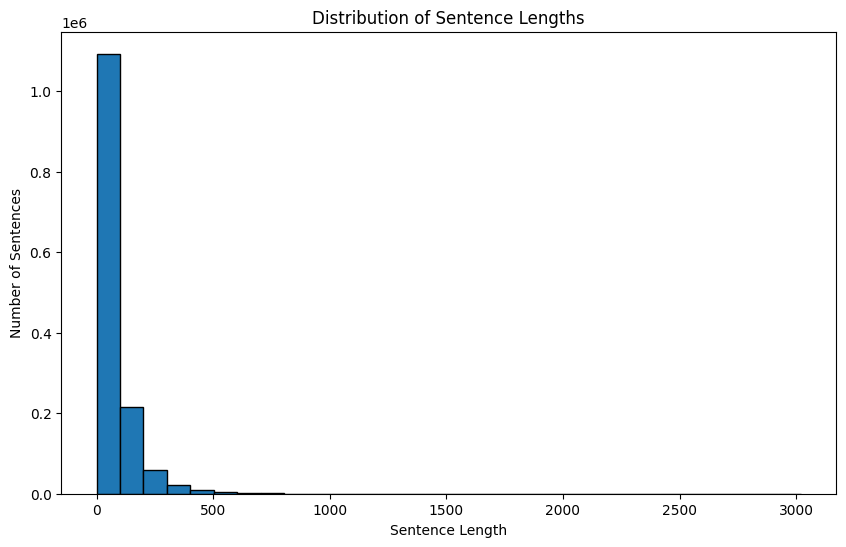

In [52]:
import matplotlib.pyplot as plt

# Define the figure size and create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the labels for the x and y axes
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Number of Sentences')

# Plot the histogram of sentence lengths
ax.hist(text_lengths, bins=30, edgecolor='black')

# Set the title for the plot
ax.set_title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

In [53]:
# Save data cleaning file to local  
data_abr_relevant.to_csv("data_cleaned.csv")

#### **B. Emotion Analysis**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Load text
text = data_abr_relevant['tokens'].tolist()

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
print("Tokenized inputs:", inputs)

# Perform inference to get the emotion scores
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    print("Logits:", logits)

# Convert logits to predicted emotion labels
predicted_class_ids = torch.argmax(logits, dim=1).numpy()
print("Predicted class IDs:", predicted_class_ids)

# Define the emotion labels according to book reviews 
emotion_labels = ["anger", "joy", "optimism", "sadness"]

# Map predicted class ids to emotion labels
predicted_emotions = [emotion_labels[class_id] for class_id in predicted_class_ids]
print("Predicted emotions:", predicted_emotions)

# Encode emotion feature using One-Hot Encoding
encoder = OneHotEncoder(sparse=False)
emotion_encoded = encoder.fit_transform(np.array(predicted_emotions).reshape(-1, 1))
print("One-Hot Encoded emotions:\n", emotion_encoded)

# Save encoder to a pkl file
with open("emotion_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

print("Encoder saved successfully.")

#### **C. Feature Extraction**

Word2Vec is preferable when semantic relationships are crucial, especially with large datasets. This approach captures the context of words in a corpus and learns word associations, making it ideal for tasks such as natural language processing, recommendation systems, and understanding word similarities. 

In [ ]:
# Assign to new dataframe
data_cleaned = data_abr_relevant

# Train Word2Vec model
data_cleaned['tokens'] = data_cleaned['tokens'].apply(ast.literal_eval)
word2vec_model = Word2Vec(sentences=data_cleaned['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Function to extract embeddings for a list of tokens
def extract_embeddings(tokens_list, model):
    embeddings = []
    for token in tokens_list:
        if token in model.wv:
            embeddings.append(model.wv[token])
        else:
            # Use zero vector for out-of-vocabulary tokens
            embeddings.append(np.zeros(model.vector_size))  
    if embeddings:
        # Average of word embeddings
        return np.mean(embeddings, axis=0)  
    else:
        # Return zero vector if no embeddings found
        return np.zeros(model.vector_size)  

# Apply the function to each row in df
data_cleaned['embedding_word'] = data_cleaned['tokens'].apply(lambda tokens: extract_embeddings(tokens, word2vec_model))

In [ ]:
# Testing: Retrieve embeddings for specific tokens and verify
test_tokens = ['aware']
test_embeddings = extract_embeddings(test_tokens, word2vec_model)
print(f"Embeddings for tokens {test_tokens}:")
print(test_embeddings)